In [1]:
%matplotlib inline

from __future__ import print_function, absolute_import

import os
import argparse
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.datasets as datasets

from pose import Bar
from pose.utils.logger import Logger, savefig
from pose.utils.evaluation import accuracy, AverageMeter, final_preds
from pose.utils.misc import save_checkpoint, save_pred, adjust_learning_rate
from pose.utils.osutils import mkdir_p, isfile, isdir, join
from pose.utils.imutils import batch_with_heatmap
from pose.utils.transforms import fliplr, flip_back
import pose.models as models
import pose.datasets as datasets

os.environ['CUDA_VISIBLE_DEVICES']='2'


In [9]:
# parameters
arch = 'hg'
stacks = 8
blocks = 1
classes = 16
weights_path = '/home/ubuntu/cvlab/meego/pytorch-pose/pretrained_weights/hg_s8_b1/model_best.pth.tar'

# construct the base Stacked Hourglass Nets model
stacked_hourglass_nets = models.__dict__[arch](num_stacks=stacks, num_blocks=blocks, num_classes=classes)
stacked_hourglass_nets = torch.nn.DataParallel(stacked_hourglass_nets).cuda()
checkpoint = torch.load(weights_path)
stacked_hourglass_nets.load_state_dict(checkpoint['state_dict']) # load pretrained weights


In [10]:
print('stacked_hourglass_nets type:', type(stacked_hourglass_nets))
stacked_hourglass_nets

stacked_hourglass_nets type: <class 'torch.nn.parallel.data_parallel.DataParallel'>


DataParallel (
  (module): HourglassNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (layer1): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (layer2): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(128, 128, k

In [11]:
# construct the pose feature extraction component from stacked hourglass networks

class PoseFeatureNet(nn.Module):
    def __init__(self, base_model):
        super(PoseFeatureNet, self).__init__()
        
        self.inplanes = base_model.inplanes
        self.num_feats = base_model.num_feats
        self.num_stacks = base_model.num_stacks
        
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.maxpool = base_model.maxpool
        
        self.hg = base_model.hg
        self.res = base_model.res
        self.fc = base_model.fc
        self.score = base_model.score
        self.fc_ = base_model.fc_
        self.score_ = base_model.score_
        
    def forward(self, x):
        # TODO: (to think)
        # feature maps(256 channels) v.s. result confidence maps(16 channels),
        # what's the difference between them w.r.t. the information contained in them?
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        fc_feature = []
        for i in range(self.num_stacks):
            y = self.hg[i](x)
            fc_feature.append(y)
            y = self.res[i](y)
            y = self.fc[i](y)
            
            score = self.score[i](y)
            out.append(score)
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_
                
        #return out
        return fc_feature

pose_feature_net = PoseFeatureNet(stacked_hourglass_nets.module)
pose_feature_net = torch.nn.DataParallel(pose_feature_net).cuda()
print ('pose_feature_net --> num_stacks?', pose_feature_net.module.num_stacks)

pose_feature_net

pose_feature_net --> num_stacks? 8


DataParallel (
  (module): PoseFeatureNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (layer1): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (layer2): Sequential (
      (0): Bottleneck (
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (conv1): Conv2d(128, 128,

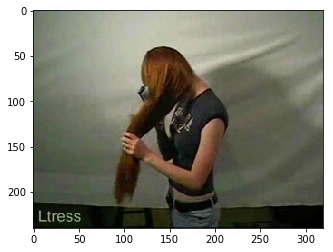

In [6]:
# TODO: visualize feature vectors coming out from extraction_component
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from torch.autograd import Variable

test_img_path = '/home/ubuntu/data/JHMDB/Rename_Images/brush_hair/red_head_brush_hair_u_cm_np1_le_goo_2/00001.png'
test_img = Image.open(test_img_path, 'r')
test_img = np.asarray(test_img)

imshow(test_img)

Loading pickle: /home/ubuntu/cvlab/pytorch/Sub-JHMDB_pose_stream/get_train_test_split/dic_train.pickle ...
images size? torch.Size([1, 3, 256, 256])

results_numpy type? <type 'numpy.ndarray'>
results_numpy.shape (1, 16, 64, 64)

features type? <type 'list'>
features len? 8


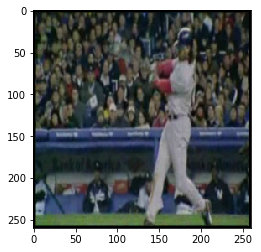

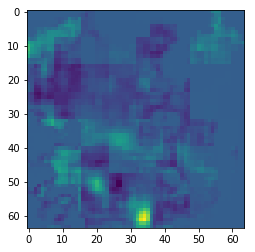

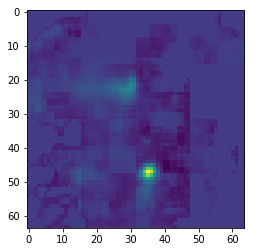

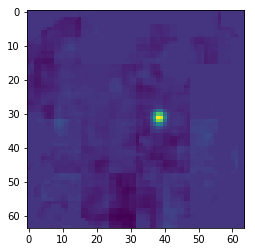

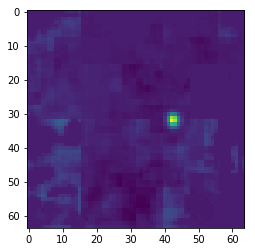

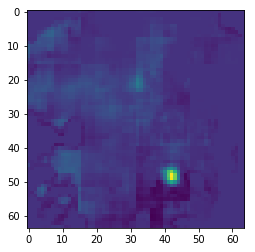

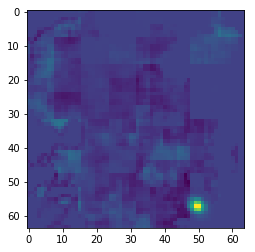

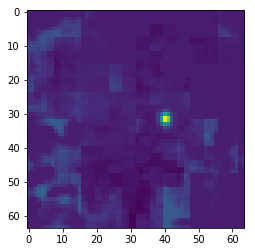

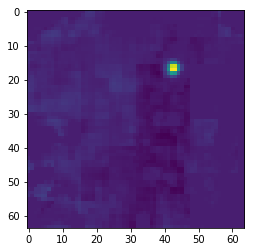

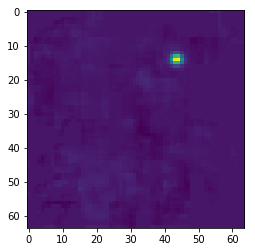

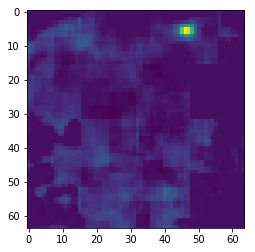

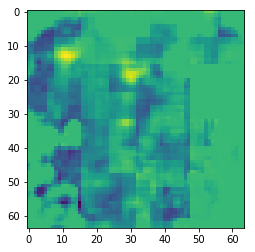

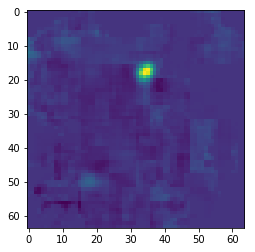

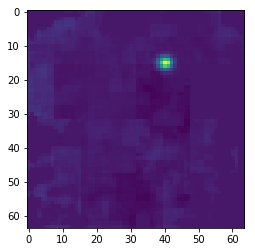

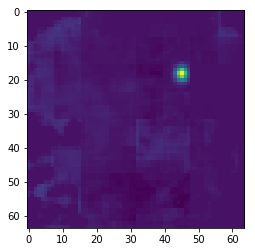

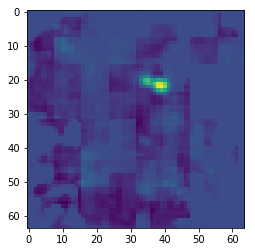

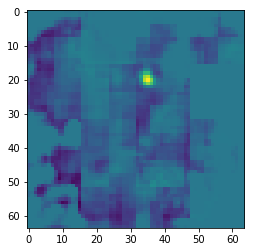

In [15]:
from utils.datasets import jhmdb
from utils import pickle_tools
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

def my_imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

jhmdb_dict_path = '/home/ubuntu/cvlab/pytorch/Sub-JHMDB_pose_stream/get_train_test_split/dic_train.pickle'
jhmdb_dict = pickle_tools.load_pickle(jhmdb_dict_path)

jhmdb_rgb_root = '/home/ubuntu/data/JHMDB/Rename_Images'
train_set = jhmdb.JhmdbRgbData(jhmdb_dict, jhmdb_rgb_root, transform=transforms.Compose([
                transforms.Scale([256, 256]),
                transforms.ToTensor()
                ]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=2)

# get some training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_cpu = images.cpu()

# show images
my_imshow(torchvision.utils.make_grid(images))
print('images size?', images.size())
print()

# use the base stacked hourglass model to inference on images
images_cuda = images.cuda()
results = stacked_hourglass_nets(Variable(images_cuda))
results_numpy = results[7].data.cpu().numpy()
print('results_numpy type?', type(results_numpy))
print('results_numpy.shape', results_numpy.shape)
print()

# display pose confidence maps generated by the base stacked hourglass model
for i in range(results_numpy.shape[0]):
    result_numpy = results_numpy[i, :, :, :]
    for c in range(result_numpy.shape[0]):
        channel = result_numpy[c, :, :]
        plt.figure()
        imshow(channel)

# try using pose_feature_net to extract feature
features = pose_feature_net(Variable(images))
print('features type?', type(features))
print('features len?', len(features))


In [31]:
import numpy as np
import pickle
from PIL import Image
import time
import shutil
from random import randint
import random
import argparse
import scipy.io

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt

class RGB_dataset(Dataset):  
    def __init__(self, dic, root_dir, anno_path, mode, nb_per_stack, transform=None):
        #Generate a 16 Frame clip
        self.keys=dic.keys()
        self.values=dic.values()
        self.root_dir = root_dir
        self.anno_path=anno_path
        self.transform = transform
        self.mode=mode
        self.nb_per_stack = 1

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        if self.mode == 'train':
            video, nb_clips = self.keys[idx].split('[@]')
            clip_idx = randint(1,int(nb_clips))
        elif self.mode == 'val':
            video,clip_idx = self.keys[idx].split('[@]')
        else:
            raise ValueError('There are only train and val mode')

        label = self.values[idx]
        label = int(label)-1

        n = video+'/'+ str(clip_idx).zfill(6)+'.jpg'
        data = Image.open(self.root_dir+n)
        
        if self.mode == 'train':
            data=self.transform(data)
            sample = (data,label)
        elif self.mode == 'val':
            data=data
            data=self.transform(data)
            sample = (video,data,label)
        else:
            raise ValueError('There are only train and val mode')
        return sample

class RGB_DataLoader():
    def __init__(self, BATCH_SIZE, num_workers, nb_per_stack, data_path, dic_path, anno_path):
        self.BATCH_SIZE=BATCH_SIZE
        self.num_workers = num_workers
        self.data_path=data_path
        self.anno_path=anno_path
        self.nb_per_stack=1
        #load data dictionary
        with open(dic_path+'/train_video.pickle','rb') as f:
            self.train_video=pickle.load(f)
        f.close()
        with open(dic_path+'/test_video.pickle','rb') as f:
            self.test_video=pickle.load(f)
        f.close()
        with open(dic_path+'frame_count.pickle','rb') as f:
            self.frame_count=pickle.load(f)
        f.close()

    def run(self):
        self.test_frame_sampling()
        self.train_video_labeling()
        train_loader = self.train()
        val_loader = self.val()
        return train_loader, val_loader
    
    def test_frame_sampling(self):  # uniformly sample 18 frames and  make a video level consenus
        self.dic_test_idx = {}
        for video in self.test_video: # dic[video] = label
            nb_frame = int(self.frame_count[video])
            interval = int(nb_frame/18)
            for i in range(18):
                clip_idx = i*interval
                key = video + '[@]' + str(clip_idx+1)
                #print key
                self.dic_test_idx[key] = self.test_video[video]

    def train_video_labeling(self):
        self.dic_video_train={}
        for video in self.train_video: # dic[video] = label

            nb_clips = self.frame_count[video]
            if nb_clips <= 0:
                raise ValueError('Invalid nb_per_stack number {} ').format(self.nb_per_stack)
            key = video +'[@]' + str(nb_clips)
            self.dic_video_train[key] = self.train_video[video]
                            
    def train(self):
        training_set = RGB_dataset(dic=self.dic_video_train, 
            root_dir=self.data_path,
            anno_path = self.anno_path,
            nb_per_stack=self.nb_per_stack,
            mode='train',
            transform=transforms.Compose([
                transforms.Scale((256, 256)),
                transforms.ToTensor()
                ]) 
            )
        #print '==> Training data :',len(training_set),' videos'
        #print training_set[1][0].size()

        train_loader = DataLoader(
            dataset=training_set, 
            batch_size=self.BATCH_SIZE,
            shuffle=True,
            num_workers=self.num_workers)
        return train_loader

    def val(self):
        validation_set = RGB_dataset(
            dic= self.dic_test_idx, 
            root_dir=self.data_path,
            anno_path = self.anno_path,
            nb_per_stack=self.nb_per_stack,
            mode ='val',
            transform=transforms.Compose([
                transforms.Scale((256, 256)),
                transforms.ToTensor()
                ]) 
            )
        #print '==> Validation data :',len(validation_set),' clips'
        #print validation_set[1][1].size()

        val_loader = DataLoader(
            dataset=validation_set, 
            batch_size=self.BATCH_SIZE, 
            shuffle=False,
            num_workers=self.num_workers)
        return val_loader


images size? torch.Size([1, 3, 256, 256])

results_numpy type? <type 'numpy.ndarray'>
results_numpy.shape (1, 16, 64, 64)

results_numpy type? <type 'numpy.ndarray'>
results_numpy.shape (1, 16, 64, 64)



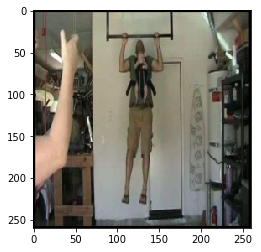

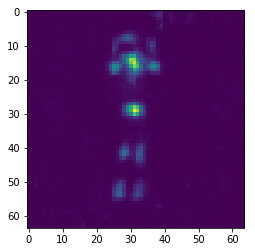

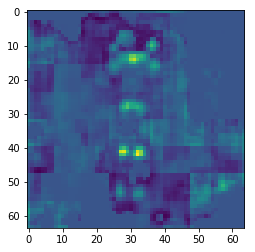

In [44]:
data_loader = RGB_DataLoader(BATCH_SIZE=1,num_workers=1,nb_per_stack=16,
                                    dic_path='/home/ubuntu/data/PennAction/Penn_Action/train_test_split/',
                                    data_path='/home/ubuntu/data/PennAction/Penn_Action/frames/',
                                    anno_path='/home/ubuntu/data/PennAction/Penn_Action/labels/'
                                    )
penn_train_loader, penn_val_loader = data_loader.run()

# get some training images
dataiter = iter(penn_train_loader)
images, labels = dataiter.next()
#dataiter = iter(penn_val_loader)
#_, images, labels = dataiter.next()
images_cpu = images.cpu()

# show images
my_imshow(torchvision.utils.make_grid(images))
print('images size?', images.size())
print()

# use the base stacked hourglass model to inference on images
images_cuda = images.cuda()
results = stacked_hourglass_nets(Variable(images_cuda))

# display pose confidence maps generated by the base stacked hourglass model
results_numpy = results[0].data.cpu().numpy()
print('results_numpy type?', type(results_numpy))
print('results_numpy.shape', results_numpy.shape)
print()

channel = 0
for i in range(results_numpy.shape[0]):
    result_numpy = results_numpy[i, :, :, :]
    for c in range(result_numpy.shape[0]):
        channel += result_numpy[c, :, :]
    plt.figure()
    imshow(channel)

# display pose confidence maps generated by the base stacked hourglass model
results_numpy = results[7].data.cpu().numpy()
print('results_numpy type?', type(results_numpy))
print('results_numpy.shape', results_numpy.shape)
print()

channel = 0
for i in range(results_numpy.shape[0]):
    result_numpy = results_numpy[i, :, :, :]
    for c in range(result_numpy.shape[0]):
        channel += result_numpy[c, :, :]
        
    plt.figure()
    imshow(channel)

        

86.25 45.75 168.75 350.25
<class 'torch.FloatTensor'>


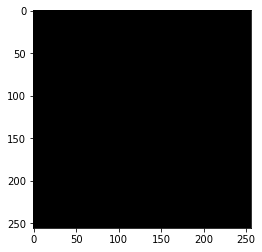

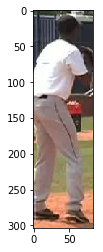

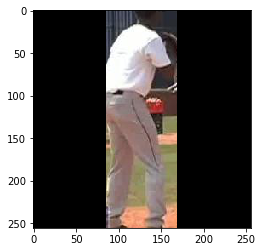

In [92]:
import scipy.io

# base image
base_size = (256, 256)
base_img = Image.new('RGB', base_size)
plt.figure()
plt.imshow(base_img)

# source image
source_img = Image.open('/home/ubuntu/data/PennAction/Penn_Action/frames/0001/000001.jpg')
anno = scipy.io.loadmat('/home/ubuntu/data/PennAction/Penn_Action/labels/0001.mat')
h0,w0,h1,w1 = anno['bbox'][0]
print(h0, w0, h1, w1)

source_img = source_img.crop([h0,w0,h1,w1])
plt.figure()
plt.imshow(source_img)

#source_img = source_img.resize((256, 256))
#plt.figure()
#plt.imshow(source_img)

old_size = source_img.size
base_img.paste(source_img, ((base_size[0] - old_size[0]) / 2, (base_size[1] - old_size[1]) / 2))
plt.figure()
plt.imshow(base_img)

# transform to tensor
img = np.array(base_img)
T = transforms.ToTensor()
img = T(img)
print(type(img))


results_numpy type? <type 'numpy.ndarray'>
results_numpy.shape (1, 16, 64, 64)

results_numpy type? <type 'numpy.ndarray'>
results_numpy.shape (1, 16, 64, 64)



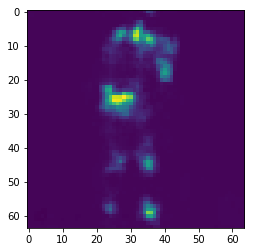

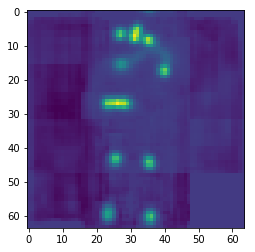

In [93]:
img_sudo_batch = img.unsqueeze(0)

img_cuda = img_sudo_batch.cuda()
results = stacked_hourglass_nets(Variable(img_cuda))

# display pose confidence maps generated by the base stacked hourglass model
results_numpy = results[0].data.cpu().numpy()
print('results_numpy type?', type(results_numpy))
print('results_numpy.shape', results_numpy.shape)
print()

channel = 0
for i in range(results_numpy.shape[0]):
    result_numpy = results_numpy[i, :, :, :]
    for c in range(result_numpy.shape[0]):
        channel += result_numpy[c, :, :]
    plt.figure()
    imshow(channel)

# display pose confidence maps generated by the base stacked hourglass model
results_numpy = results[7].data.cpu().numpy()
print('results_numpy type?', type(results_numpy))
print('results_numpy.shape', results_numpy.shape)
print()

channel = 0
for i in range(results_numpy.shape[0]):
    result_numpy = results_numpy[i, :, :, :]
    for c in range(result_numpy.shape[0]):
        channel += result_numpy[c, :, :]
        
    plt.figure()
    imshow(channel)
